In [23]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import WordPunctTokenizer 
import string 
import csv
import gensim
from gensim import corpora
import re
import pandas as pd
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brittanysteenbergen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brittanysteenbergen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brittanysteenbergen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import sys
print(sys.path)

['/Users/brittanysteenbergen/git/thesis', '/opt/anaconda3/lib/python38.zip', '/opt/anaconda3/lib/python3.8', '/opt/anaconda3/lib/python3.8/lib-dynload', '', '/opt/anaconda3/lib/python3.8/site-packages', '/opt/anaconda3/lib/python3.8/site-packages/aeosa']


In [4]:
# demonstrating how the file looks when originally opened

file = open('mathematics.txt', 'r')
lines = file.readlines()
lines = [line.lower() for line in lines]
for line in lines:
    print(line)

what are your plans after graduation?

would you like to provide a non-lmu email so we can contact you after graduation? you can also join in the lmu math department linkedin network.

student-faculty relationship and department environment: during your time in the math department, how do you feel about

your relation and interaction with faculty in the math department

student-student relationships in the department

advising: how do you feel about

academic program advising in mathematics

the way advisors are assigned

career advising

advising on personal matters if relevant

lower-division experience: what are your thoughts on

lower division course work in math 

the level of difficulty of lower division math courses 

transition from high school to university

non-course experiences, e.g. dorms, added freedom, etc.

upper division experience: what are your thoughts on

difficulty level of upper division math courses

variety and availability of upper division math courses

trans

In [5]:
# document processing using the clean function suggestion from Analytics Vidya

doc_complete = lines

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized
    
doc_clean = [clean(doc).split() for doc in doc_complete] 
print(doc_clean)

[['plan', 'graduation'], ['would', 'like', 'provide', 'nonlmu', 'email', 'contact', 'graduation', 'also', 'join', 'lmu', 'math', 'department', 'linkedin', 'network'], ['studentfaculty', 'relationship', 'department', 'environment', 'time', 'math', 'department', 'feel'], ['relation', 'interaction', 'faculty', 'math', 'department'], ['studentstudent', 'relationship', 'department'], ['advising', 'feel'], ['academic', 'program', 'advising', 'mathematics'], ['way', 'advisor', 'assigned'], ['career', 'advising'], ['advising', 'personal', 'matter', 'relevant'], ['lowerdivision', 'experience', 'thought'], ['lower', 'division', 'course', 'work', 'math'], ['level', 'difficulty', 'lower', 'division', 'math', 'course'], ['transition', 'high', 'school', 'university'], ['noncourse', 'experience', 'eg', 'dorm', 'added', 'freedom', 'etc'], ['upper', 'division', 'experience', 'thought'], ['difficulty', 'level', 'upper', 'division', 'math', 'course'], ['variety', 'availability', 'upper', 'division', 'mat

In [6]:
# document processing using nltk
# https://towardsdatascience.com/text-normalization-with-spacy-and-nltk-1302ff430119

doc_complete = lines
tk = WordPunctTokenizer() 

def tokenizing_nltk(doc):
    # tokenize
    doc_tokenized = tk.tokenize(doc)

    # stemming
    # nltk_stemedList = []
    # for word in doc_tokenized:
    #     nltk_stemedList.append(p_stemmer.stem(word))
    # print(nltk_stemedList)

    # lematize
    wordnet_lemmatizer = WordNetLemmatizer()
    nltk_lemmaList = []
    for word in doc_tokenized:
        nltk_lemmaList.append(wordnet_lemmatizer.lemmatize(word))

    # filter stopword
    filtered_sentence = []  
    nltk_stop_words = set(stopwords.words("english"))
    my_stop_words = {"I", "4", "ha", "c", ")", ").", "|", "3", "-", "(","–", "e"}
    
    for w in nltk_lemmaList:  
        if w not in nltk_stop_words and w not in my_stop_words:  
            filtered_sentence.append(w)

    # removing punctuation
    punctuations="?:!.,;-"
    for word in filtered_sentence:
        if word in punctuations:
            filtered_sentence.remove(word)

    return filtered_sentence

doc_tokenized = [tokenizing_nltk(doc) for doc in doc_complete] 
print(doc_tokenized)

[['plan', 'graduation'], ['would', 'like', 'provide', 'non', 'lmu', 'email', 'contact', 'graduation', 'also', 'join', 'lmu', 'math', 'department', 'linkedin', 'network'], ['student', 'faculty', 'relationship', 'department', 'environment', 'time', 'math', 'department', 'feel'], ['relation', 'interaction', 'faculty', 'math', 'department'], ['student', 'student', 'relationship', 'department'], ['advising', 'feel'], ['academic', 'program', 'advising', 'mathematics'], ['way', 'advisor', 'assigned'], ['career', 'advising'], ['advising', 'personal', 'matter', 'relevant'], ['lower', 'division', 'experience', 'thought'], ['lower', 'division', 'course', 'work', 'math'], ['level', 'difficulty', 'lower', 'division', 'math', 'course'], ['transition', 'high', 'school', 'university'], ['non', 'course', 'experience', 'g', 'dorm', 'added', 'freedom', 'etc', '.'], ['upper', 'division', 'experience', 'thought'], ['difficulty', 'level', 'upper', 'division', 'math', 'course'], ['variety', 'availability', '

In [7]:
# preparing document term matrix to be used for lda with the clean function

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_clean = corpora.Dictionary(doc_clean)

# Converting corpus into Document Term Matrix using dictionary prepared above.
doc_term_matrix_clean = [dictionary_clean.doc2bow(doc) for doc in doc_clean]

In [8]:
# preparing document term matrix to be used for lda with the nltk preprocessing

dictionary_tokenized = corpora.Dictionary(doc_tokenized)
doc_term_matrix_tokenized = [dictionary_tokenized.doc2bow(doc) for doc in doc_tokenized]

In [9]:
# lda model from the clean function 
# Skeleton from https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/#h-latent-dirichlet-allocation-for-topic-modeling

# Creating the object for LDA model using gensim library
Lda = gensim.models.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix_clean, num_topics=5, id2word = dictionary_clean, passes=50)

print(ldamodel.show_topics(num_words=10, formatted=False))

[(0, [('experience', 0.04919708), ('advising', 0.033901043), ('mathematics', 0.03386346), ('thought', 0.033792935), ('department', 0.033693668), ('graduation', 0.018497879), ('network', 0.018468454), ('nonlmu', 0.018468454), ('also', 0.018468454), ('provide', 0.018468454)]), (1, [('advising', 0.057619724), ('career', 0.05717654), ('work', 0.055915486), ('lower', 0.009574114), ('course', 0.00956222), ('math', 0.009554242), ('division', 0.009547975), ('studentstudent', 0.009536081), ('comment', 0.009535023), ('suggestion', 0.009532698)]), (2, [('division', 0.14242996), ('math', 0.11220636), ('course', 0.08307042), ('upper', 0.08306613), ('lower', 0.06327083), ('level', 0.043534994), ('difficulty', 0.043534994), ('variety', 0.023745963), ('availability', 0.023745963), ('plan', 0.023744479)]), (3, [('department', 0.08668364), ('feel', 0.065950066), ('math', 0.056350376), ('relationship', 0.045271285), ('confidence', 0.024716819), ('ability', 0.024716819), ('studentfaculty', 0.024706397), (

In [10]:
# lda model from the nltk preprocessing

Lda = gensim.models.LdaModel
ldamodel = Lda(doc_term_matrix_tokenized, num_topics=5, id2word = dictionary_tokenized, passes=50)
print(ldamodel.show_topics(num_words=10, formatted=False))

[(0, [('division', 0.15346906), ('math', 0.11620986), ('course', 0.07869039), ('upper', 0.078595266), ('lower', 0.07859518), ('level', 0.04117952), ('difficulty', 0.04117952), ('transition', 0.022487462), ('see', 0.022461403), ('249', 0.022461403)]), (1, [('lmu', 0.06352775), ('advising', 0.03808996), ('graduation', 0.034820426), ('department', 0.034709137), ('non', 0.034656074), ('would', 0.034643214), ('provide', 0.03462812), ('network', 0.034628112), ('like', 0.034628112), ('linkedin', 0.034628112)]), (2, [('advising', 0.076804906), ('feel', 0.076520115), ('versus', 0.044187326), ('relevant', 0.04418723), ('personal', 0.04418723), ('matter', 0.04418723), ('unit', 0.044125676), ('course', 0.044104278), ('math', 0.044031747), ('comment', 0.0073669255)]), (3, [('feel', 0.06361429), ('course', 0.06359967), ('unit', 0.063520275), ('mathematics', 0.063486494), ('student', 0.043672215), ('ability', 0.0436468), ('confidence', 0.0436468), ('department', 0.043533996), ('time', 0.02382034), ('

In [11]:
# optimizing choice of topics through coherence
# referenced from https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2

coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix_tokenized, num_topics=k, \
               id2word = dictionary_tokenized, passes=40,\
               iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=doc_tokenized,\
         dictionary=dictionary_tokenized, coherence='c_v')   
                                                
    coherence.append((k,cm.get_coherence()))

print(coherence)

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
[(5, 0.48643707361977884), (6, 0.5196115782076632), (7, 0.48159871882798305), (8, 0.5466300912200022), (9, 0.5559468250447418), (10, 0.4944897998560728), (11, 0.4908459478830906), (12, 0.4958389910346687), (13, 0.4870309330630215), (14, 0.4942775661228875), (15, 0.5030115277067169), (16, 0.4947070001208329), (17, 0.4866508090527387), (18, 0.4959342749837404), (19, 0.48497430045628426), (20, 0.49600921615394533), (21, 0.5006023432130784), (22, 0.4867504866479196), (23, 0.4943196930244395), (24, 0.49359046367627296)]


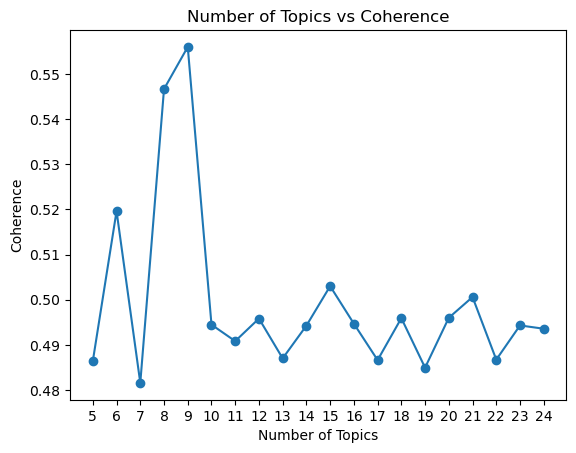

In [12]:
# coherence plot to assist in optimal value

x = [item[0] for item in coherence]
y = [item[1] for item in coherence]

plt.plot(range(len(coherence)), y, marker='o', linestyle='-')
plt.xticks(range(len(coherence)), x)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.title('Number of Topics vs Coherence')
plt.show()

In [52]:
# this was the decided model to use after observing different hyperparameters below

Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix_tokenized, num_topics = 9, alpha = 0.1, id2word = dictionary_tokenized, passes = 50)
model = ldamodel.show_topics(num_words=3, formatted=False)
print(model)

[(0, [('thought', 0.13440916), ('experience', 0.12591411), ('division', 0.117130026)]), (1, [('student', 0.16101755), ('relationship', 0.08474564), ('department', 0.084745586)]), (2, [('course', 0.10462884), ('unit', 0.094382934), ('feel', 0.094382845)]), (3, [('department', 0.09999942), ('ability', 0.052631848), ('confidence', 0.052631848)]), (4, [('department', 0.09134732), ('feel', 0.04807703), ('time', 0.048076946)]), (5, [('advising', 0.012195124), ('relevant', 0.012195123), ('personal', 0.012195123)]), (6, [('math', 0.107869625), ('lmu', 0.055394195), ('division', 0.05539407)]), (7, [('math', 0.09281043), ('course', 0.08470859), ('division', 0.07958021)]), (8, [('transition', 0.07874041), ('university', 0.07874), ('school', 0.07874)])]


In [53]:
vis = gensimvis.prepare(ldamodel, doc_term_matrix_tokenized, dictionary = dictionary_tokenized)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.159947 -0.116501       1        1  28.728063
2     -0.202262 -0.117576       2        1  21.247559
6      0.148639  0.081053       3        1  18.899521
4     -0.074032  0.099317       4        1   9.276660
3     -0.070812  0.062615       5        1   7.942255
0      0.068946 -0.060227       6        1   4.982904
8     -0.003406  0.011059       7        1   3.927530
1     -0.022474  0.057747       8        1   3.578987
5     -0.004545 -0.017487       9        1   1.416521, topic_info=          Term      Freq     Total Category  logprob  loglift
34    division  6.000000  6.000000  Default  30.0000  30.0000
4   department  4.000000  4.000000  Default  29.0000  29.0000
35  experience  3.000000  3.000000  Default  28.0000  28.0000
19     student  1.000000  1.000000  Default  27.0000  27.0000
37     thought  1.000000  1.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
65  confidence  0.026085  1.859503   Topic9  -4.4067  -0.0097
2         also  0.026085  1.303665   Topic9  -4.4067   0.3454
3      contact  0.026085  1.303665   Topic9  -4.4067   0.3454
5        email  0.026085  1.303665   Topic9  -4.4067   0.3454
6         join  0.026085  1.303665   Topic9  -4.4067   0.3454

[428 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
70        1  0.744843        ,
46        1  0.938838        .
55        3  0.767068      249
60        2  0.774339        5
64        2  0.537778  ability
...     ...       ...      ...
79        1  0.744843  whether
39        1  0.744844     work
14        1  0.478152    would
14        3  0.478152    would
69        2  0.774339  writing

[102 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 3, 7, 5, 4, 1, 9, 2, 6])

In [56]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix_tokenized, num_topics = 9, alpha = 0.01, id2word = dictionary_tokenized, passes = 50)
model = ldamodel.show_topics(num_words=3, formatted=False)
print(model)

[(0, [('high', 0.055248518), ('matter', 0.055248518), ('advising', 0.055248518)]), (1, [('feel', 0.087557636), ('department', 0.087557636), ('relationship', 0.046082873)]), (2, [('career', 0.09999975), ('advising', 0.09999975), ('math', 0.010000085)]), (3, [('course', 0.12441932), ('math', 0.11980746), ('division', 0.115903355)]), (4, [('unit', 0.09319923), ('course', 0.09319923), ('feel', 0.09319923)]), (5, [('lmu', 0.07567589), ('department', 0.051351454), ('would', 0.051351443)]), (6, [('student', 0.16101687), ('department', 0.08474562), ('relationship', 0.08474562)]), (7, [('course', 0.06134961), ('g', 0.06134961), ('etc', 0.06134961)]), (8, [('division', 0.14670858), ('upper', 0.1124315), ('math', 0.089377336)])]


In [57]:
vis = gensimvis.prepare(ldamodel, doc_term_matrix_tokenized, dictionary = dictionary_tokenized)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.091387  0.171548       1        1  22.996643
5     -0.016531 -0.165413       2        1  21.184789
8      0.203223  0.021326       3        1  18.044381
3      0.145418  0.075866       4        1  10.301570
1     -0.113153  0.063726       5        1   9.929798
0     -0.044794 -0.055615       6        1   7.278585
7      0.009245 -0.054044       7        1   6.069519
6     -0.061205 -0.033801       8        1   2.758982
2     -0.030816 -0.023593       9        1   1.435734, topic_info=          Term     Freq     Total Category  logprob  loglift
34    division  6.00000  6.000000  Default  30.0000  30.0000
23    advising  2.00000  2.000000  Default  29.0000  29.0000
4   department  4.00000  4.000000  Default  28.0000  28.0000
38      course  6.00000  6.000000  Default  27.0000  27.0000
19     student  1.00000  1.000000  Default  26.0000  26.0000
..         ...      ...       ...      ...      ...      ...
7         like  0.02168  1.347959   Topic9  -4.6052   0.1135
8     linkedin  0.02168  1.347959   Topic9  -4.6052   0.1135
11     network  0.02168  1.347959   Topic9  -4.6052   0.1135
12         non  0.02168  1.853999   Topic9  -4.6052  -0.2052
13     provide  0.02168  1.347959   Topic9  -4.6052   0.1135

[443 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
70        2  0.741863        ,
46        2  0.539375        .
46        7  0.539375        .
55        3  0.760440      249
60        1  0.736887        5
...     ...       ...      ...
29        6  0.895780      way
79        2  0.741863  whether
39        4  0.832853     work
14        2  0.940701    would
69        1  0.736887  writing

[106 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 9, 4, 2, 1, 8, 7, 3])

In [58]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix_tokenized, num_topics = 9, alpha = 0.1, id2word = dictionary_tokenized, passes = 100)
model = ldamodel.show_topics(num_words=3, formatted=False)
print(model)

[(0, [('department', 0.15164113), ('student', 0.11475387), ('math', 0.07786936)]), (1, [('course', 0.058408663), ('advising', 0.04549012), ('experience', 0.045488063)]), (2, [('course', 0.12802938), ('unit', 0.1280278), ('feel', 0.06574395)]), (3, [('experience', 0.04608357), ('math', 0.04608321), ('would', 0.046083037)]), (4, [('feel', 0.11475441), ('mathematics', 0.07786929), ('confidence', 0.07786879)]), (5, [('suggestion', 0.09999997), ('department', 0.09999811), ('advising', 0.010000025)]), (6, [('transition', 0.084746614), ('university', 0.084745534), ('school', 0.084745534)]), (7, [('advising', 0.012195126), ('career', 0.012195124), ('comment', 0.012195124)]), (8, [('division', 0.12518072), ('math', 0.10974768), ('lower', 0.0634478)])]


In [59]:
vis = gensimvis.prepare(ldamodel, doc_term_matrix_tokenized, dictionary = dictionary_tokenized)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.202718  0.018692       1        1  33.940123
2      0.036932 -0.029194       2        1  14.691160
0     -0.004816 -0.196343       3        1  11.803577
4      0.181068  0.018033       4        1  11.120602
3     -0.053485  0.058299       5        1  10.788023
1      0.029541  0.121049       6        1  10.331048
6      0.007839  0.022567       7        1   3.578982
5      0.001272 -0.025522       8        1   2.329964
7      0.004368  0.012420       9        1   1.416520, topic_info=          Term      Freq     Total Category  logprob  loglift
4   department  4.000000  4.000000  Default  30.0000  30.0000
58        unit  3.000000  3.000000  Default  29.0000  29.0000
34    division  6.000000  6.000000  Default  28.0000  28.0000
38      course  7.000000  7.000000  Default  27.0000  27.0000
17        feel  4.000000  4.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
44  transition  0.026085  1.762728   Topic9  -4.4067   0.0437
52       upper  0.026085  3.723390   Topic9  -4.4067  -0.7041
2         also  0.026085  1.350546   Topic9  -4.4067   0.3101
3      contact  0.026085  1.350546   Topic9  -4.4067   0.3101
5        email  0.026085  1.350546   Topic9  -4.4067   0.3101

[442 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
70        5  0.809571        ,
46        5  0.533657        .
46        6  0.533657        .
55        1  0.740442      249
60        2  0.799716        5
...     ...       ...      ...
79        5  0.809571  whether
39        1  0.740442     work
14        1  0.493544    would
14        5  0.493544    would
69        4  0.848188  writing

[98 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 3, 1, 5, 4, 2, 7, 6, 8])

In [26]:
top_words_per_topic = []
for t in range(ldamodel.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in ldamodel.show_topic(t, topn = 3)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words.csv")